<h1> Uniform Manifold Approximation and Projection </h1>  

<h3>https://ichi.pro/ko/cheoeumbuteo-umapeul-peulogeulaeminghaneun-bangbeob-253918307112446 / https://arxiv.org/pdf/1802.03426.pdf 를 많이 참조함 </h3>

In [131]:
import pandas as pd 
import numpy as np
from sklearn import datasets
import sklearn
import matplotlib.pyplot as plt
from scipy import optimize
from tqdm import trange
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.manifold import SpectralEmbedding

import matplotlib.animation as animation

In [198]:
class UMAP(object):
    def __init__(self, n_neighbors:int, n_components:int, min_dist:float = .1, spread:float = 1., n_epoch = 300, random_state = None):
        self.n_neighbors = n_neighbors
        if min_dist > 1:
            raise ValueError('min dist must be same or lower than 1')
        else:
            self.min_dist = min_dist
        self.n_components = n_components
        self.n_epoch = n_epoch
        self.random_state = random_state
        self.spread = spread
        
    def fit_transform(self, X):
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        self.n_ = X.shape[0]
        rgen = np.random.RandomState(self.random_state)
        
        #step1. construct high-dimention prop P
        dist = euclidean_distances(X,X)
        rho = np.where(dist.argsort(0).argsort(0)==1, dist, 0).sum(axis = 0)
        dist = np.maximum(np.zeros(shape = dist.shape), dist - np.column_stack([rho for _ in range(self.n_)]))
        
        sigma = []
        def compute_sum_prop(sigma, row):
            return np.sum(np.exp(-(row/sigma)))       
        for row in dist:
            sigma_l = 0.
            sigma_h = 1000.
            for i in range(100):
                sigma_c = (sigma_l + sigma_h)/2.
                c_s = compute_sum_prop(sigma_c, row)
                if self.n_neighbors - c_s < 1e-5:
                    sigma.append(c_s)
                    break
                if c_s < self.n_neighbors:
                    sigma_l = sigma_c
                else:
                    sigma_h = sigma_c
        
        P = np.exp( -(dist / np.column_stack([sigma for _ in range(len(dist))])) )
        P = P + P.T - (P*P.T)
        
        #step2. construct low dimension and compute hyperparameter a and b
        try :
            reducer = SpectralEmbedding(n_components = self.n_components, n_neighbors = self.n_neighbors, random_state = self.random_state)
            self.low_dimension_ = reducer.fit_transform(P)
        except:
            self.low_dimension_ = rgen.standard_t(loc = 0., scale = 1 , size = self.n_ * self.n_components).reshape(self.n, self.n_components)
        
        dist_low_dim_ = lambda dist, a, b: np.power(( 1 + a * np.power(dist, 2*b) ), -1)
        def get_a_b_(min_dist):
            x = np.linspace(0,3,300)
            y = np.where(x <= min_dist, 1, np.exp(-x + min_dist))
            p, _ = optimize.curve_fit(dist_low_dim_, x, y)
            return p
        self.a_, self.b_ = get_a_b_(self.min_dist)
        
        #step3. adjust low dimension location by gradient descent for n_iter times
        alpha = 1.
        
        for i in trange(1, self.n_epoch+1):
            low_dimension_grad_ = []
            self.low_dimension_ = self.low_dimension_ - (alpha * low_dimension_grad_)
            alpha = 1. - (i / self.n_epoch)
        
        return self.low_dimension_
        

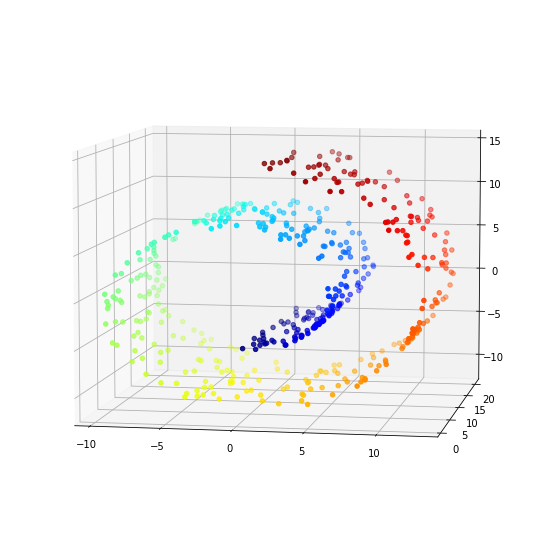

In [199]:
X, color = datasets.make_swiss_roll(random_state=42, n_samples = 500)
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(7, -80)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=color, cmap=plt.cm.jet)

In [200]:
umap = UMAP(n_neighbors=30, n_components=3, min_dist = .1, n_epoch= 50)

In [202]:
umap.fit_transform(X)

array([[ 0.        ,  9.88992919, 20.36881504, ..., 16.93576678,
         9.21217052,  8.58914372],
       [10.40200964,  0.        , 21.75635295, ..., 18.003125  ,
         8.75587269,  4.52295032],
       [20.55675602, 21.43221348,  0.        , ...,  6.42005649,
        26.04302849, 23.25202919],
       ...,
       [17.34840325, 17.90368102,  6.64475198, ...,  0.        ,
        23.91717994, 18.59409898],
       [ 9.5384032 ,  8.57002491, 26.18132018, ..., 23.83077614,
         0.        , 10.04713966],
       [ 9.26067824,  4.68240438, 23.73562273, ..., 18.85299702,
        10.3924415 ,  0.        ]])

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

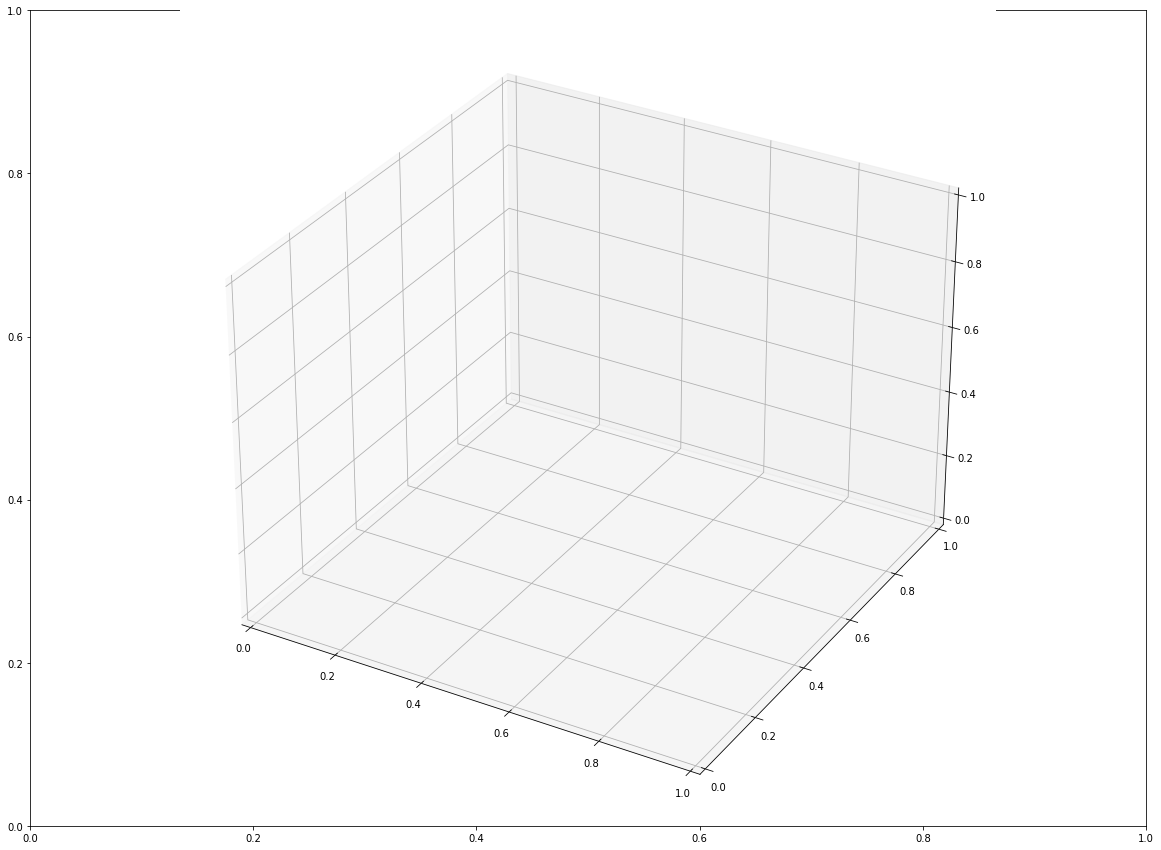

In [201]:
fig, ax = plt.subplots(figsize = (20,15))
ax = fig.add_subplot(111, projection = '3d')

ax.scatter(red[:,0], red[:,1], red[:,2], c = color, cmap = plt.cm.jet)

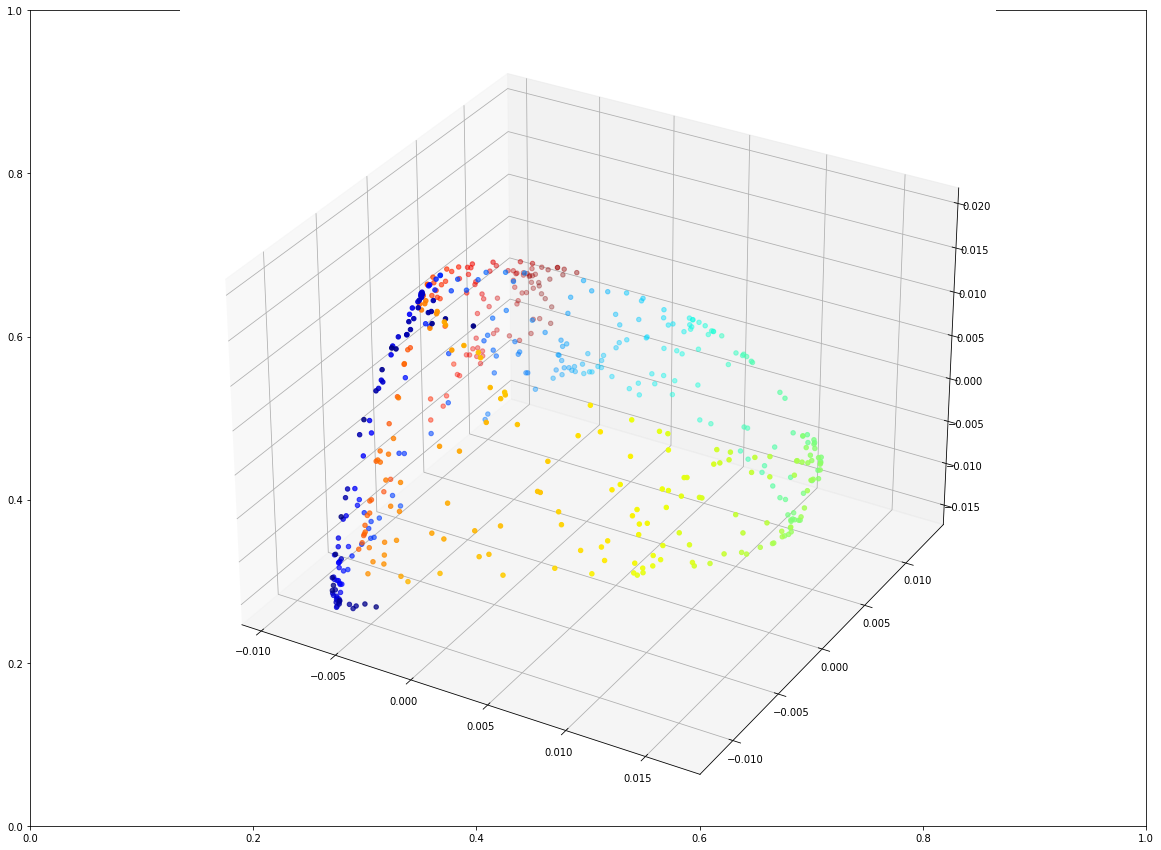

In [169]:
se = SpectralEmbedding(n_components=3, n_neighbors=30, random_state=42)
red2 = se.fit_transform(X)

fig, ax = plt.subplots(figsize = (20,15))
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(red2[:,0],red2[:,1],red2[:,2], c = color, cmap = plt.cm.jet)

In [204]:
a = np.arange(4)
a

array([0, 1, 2, 3])

In [205]:
np.expand_dims(a, axis=0) - np.expand_dims(a,axis = 1)

array([[ 0,  1,  2,  3],
       [-1,  0,  1,  2],
       [-2, -1,  0,  1],
       [-3, -2, -1,  0]])